In [34]:
# This file is currently outside the notebooks folder
import argparse
import datetime
import importlib.util
import logging
import os
import random
import shutil
import sys
from pathlib import Path
from statistics import mean, stdev
from typing import Any, DefaultDict, Tuple
import geopandas as gpd
import rasterio

import kornia.augmentation as K
import torch
import wandb
from torch.nn.modules import Module
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchgeo.datasets import NAIP, random_bbox_assignment, stack_samples
from torchmetrics.classification import MulticlassJaccardIndex

from data.dem import KaneDEM
from data.kc import KaneCounty
from data.sampler import BalancedGridGeoSampler, BalancedRandomBatchGeoSampler
from model import SegmentationModel
from utils.plot import find_labels_in_ground_truth, plot_from_tensors
from utils.transforms import apply_augs, create_augmentation_pipelines

MODEL_DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)


In [36]:
"""
This is a copy of config.py as the following cells use
paths and functions defined in this file

This module contains configuration settings.
"""

import os

# data paths
DATA_ROOT = "/net/projects/cmap/data"
KC_SHAPE_ROOT = os.path.join(DATA_ROOT, "kane-county-data")
KC_IMAGE_ROOT = os.path.join(DATA_ROOT, "KC-images")
KC_RIVER_ROOT = os.path.join(DATA_ROOT, "KC-river-images")
KC_DEM_ROOT = None
KC_DEM_ROOT = os.path.join(KC_SHAPE_ROOT, "KC_DEM_2017")
KC_MASK_ROOT = os.path.join(DATA_ROOT, "KC-masks/separate-masks")
OUTPUT_ROOT = f"/net/projects/cmap/workspaces/{os.environ['USER']}"

# model selection
MODEL = "deeplabv3+"
BACKBONE = "resnet101"
# check backbone, mean, and std when setting weights
WEIGHTS = True

# model hyperparams
DATASET_MEAN = [
    0.3281668683529412,
    0.4208941459215686,
    0.4187784871764706,
    0.5470313711372549,
]
DATASET_STD = [
    0.030595504117647058,
    0.02581302749019608,
    0.025523325960784313,
    0.03643713776470588,
]
BATCH_SIZE = 16
PATCH_SIZE = 256
NUM_CLASSES = 5  # predicting 4 classes + background
LR = 1e-4
NUM_WORKERS = 8
EPOCHS = 30
IGNORE_INDEX = 0  # index in images to ignore for jaccard index
LOSS_FUNCTION = "JaccardLoss"  # JaccardLoss, DiceLoss, TverskyLoss, LovaszLoss
PATIENCE = 5
THRESHOLD = 0.01
WEIGHT_DECAY = 0
REGULARIZATION_TYPE = None
REGULARIZATION_WEIGHT = 1.0e-5
GRADIENT_CLIPPING = False
CLIP_VALUE = 1.0

# data augmentation
SPATIAL_AUG_INDICES = [
    0,  # HorizontalFlip
    1,  # VerticalFlip
    2,  # Rotate
    3,  # Affine
    4,  # Elastic
    5,  # Perspective
    6,  # ResizedCrop
]

# only applied to images-- not masks
IMAGE_AUG_INDICES = [
    0,  # Contrast
    1,  # Brightness
    2,  # Gaussian Noise
    3,  # Gaussian Blur0
    # 4,  # Plasma Brightness
    5,  # Saturation
    # 6,  # Channel Shuffle
    # 7,  # Gamma
]

# Augmentation
ROTATION_DEGREES = 360
COLOR_CONTRAST = 0.3  # tuned
COLOR_BRIGHTNESS = 0.3  # tuned
RESIZED_CROP_SIZE = (PATCH_SIZE, PATCH_SIZE)
GAUSSIAN_NOISE_PROB = 0.5  # tuned
GAUSSIAN_NOISE_STD = 0.1  # tuned
GAUSSIAN_BLUR_SIGMA = (0.3, 0.4)  # tuned
GAUSSIAN_BLUR_KERNEL = (7, 7)  # tuned
PLASMA_ROUGHNESS = (0.0, 0.2)
PLASMA_BRIGHTESS = (0.1, 0.3)
SATURATION_LIMIT = 0.3  # tuned
SHADOW_INTENSITY = (-0.05, 0.0)
SHADE_QUANTITY = (0.0, 0.05)
GAMMA = (0.8, 1.2)


SPATIAL_AUG_MODE = "all"  # all or random
COLOR_AUG_MODE = "all"  # all or random

# KaneCounty data
KC_SHAPE_FILENAME = "KC_StormwaterDataJan2024.gdb.zip"
KC_LAYER = 4
KC_LABELS = {
    "BACKGROUND": 0,
    "POND": 1,
    "WETLAND": 2,
    "DRY BOTTOM - TURF": 3,
    "DRY BOTTOM - MESIC PRAIRIE": 4,
}

# for wandb
WANDB_API = ""

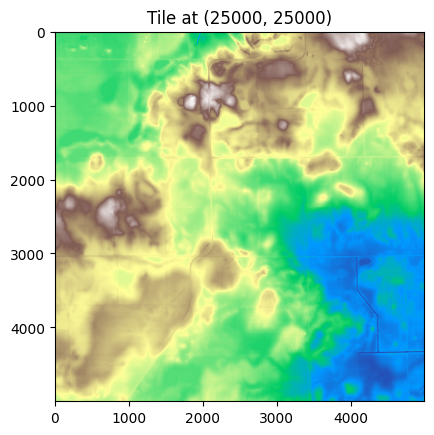

In [40]:
#plotting a sample piece of the DEM data
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt

# Path to your DEM file
dem_path = '/net/projects/cmap/data/kane-county-data/KC_DEM_2017/Kane2017BE'

# Define tile size (adjust based on your memory capacity)
tile_width, tile_height = 5000, 5000

# Open DEM and get dimensions
with rasterio.open(dem_path) as src:
    for i in range(0, src.width, tile_width)[5:6]:
        for j in range(0, src.height, tile_height)[5:6]:
            # Create a window for the current tile
            window = Window(i, j, tile_width, tile_height)
            tile = src.read(1, window=window)

            # Plot the tile (or process as needed)
            plt.imshow(tile, cmap='terrain')
            plt.title(f'Tile at ({i}, {j})')

In [41]:
#creating a data reader for the DEM data
src = rasterio.open(dem_path)

In [46]:
#obtaining the actual DEM data from the data reader
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs
    dem_bounds=src.bounds

In [47]:
#this function transforms pixel co-ordinates to map co-ordinates.
#however this function crashes the cluster
'''import numpy as np
def get_coordinates(dem_data, transform):
    rows, cols = dem_data.shape
    x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))

    # Convert pixel coordinates to map coordinates
    eastings, northings = rasterio.transform.xy(transform, y_coords, x_coords)

    return np.array(eastings), np.array(northings)

eastings, northings = get_coordinates(dem_data, transform)'''

'import numpy as np\ndef get_coordinates(dem_data, transform):\n    rows, cols = dem_data.shape\n    x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))\n\n    # Convert pixel coordinates to map coordinates\n    eastings, northings = rasterio.transform.xy(transform, y_coords, x_coords)\n\n    return np.array(eastings), np.array(northings)\n\neastings, northings = get_coordinates(dem_data, transform)'

In [48]:
#importing NAIP class
from torchgeo.datasets import NAIP, random_bbox_assignment, stack_samples

In [49]:
#creating a preprocessor to convert the NAIP data to float
#and normalize
def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample
naip_dataset = NAIP(KC_IMAGE_ROOT,crs,transforms=preprocess)

In [50]:
from data.sampler import BalancedGridGeoSampler, BalancedRandomBatchGeoSampler

In [51]:
sampler = BalancedGridGeoSampler(config={
    "dataset": naip_dataset,
    "size": 256,
    "stride": 256,
    "units" : crs
})
first_item = next(iter(sampler))

In [52]:
#checking the bounding box of the first sample
first_item

BoundingBox(minx=920685.1803786717, maxx=920941.1803786717, miny=1918779.362294658, maxy=1919035.362294658, mint=1632805200.0, maxt=1632891599.999999)

In [55]:
from rasterio.plot import show
from rasterio.plot import show_hist

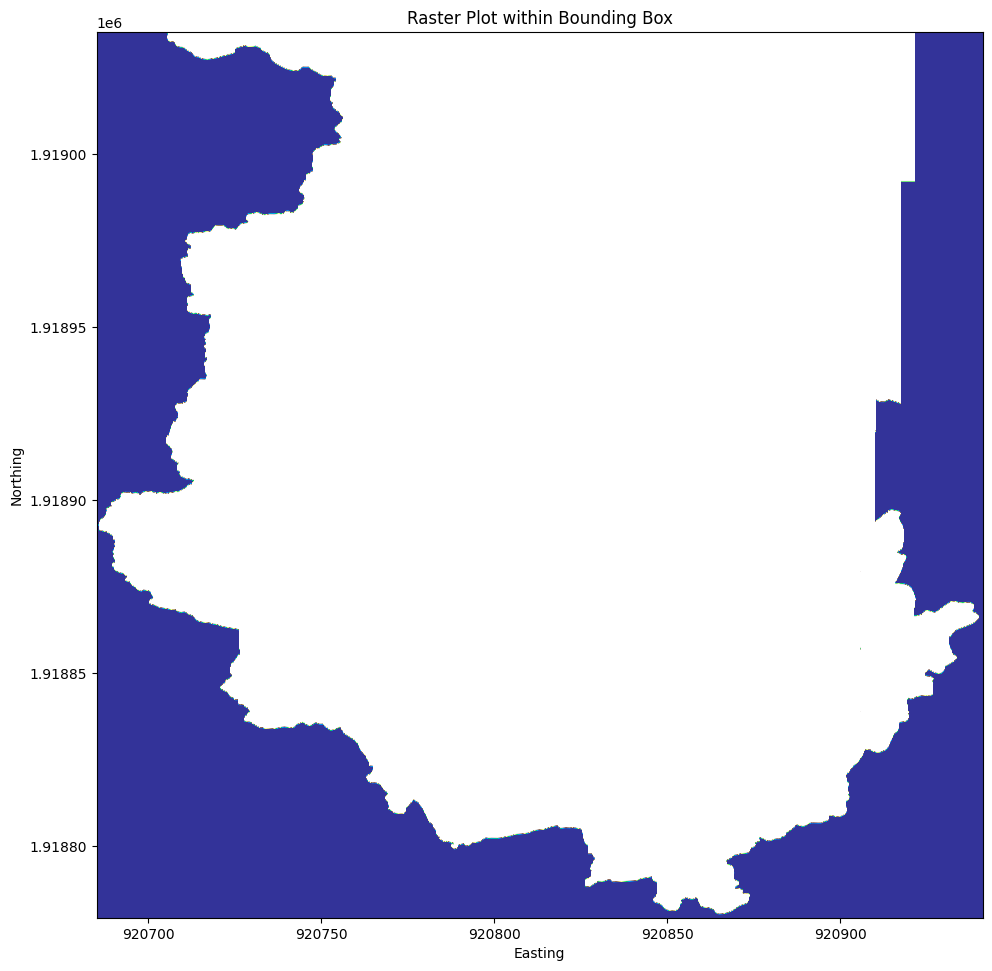

In [57]:
#unsuccesful attempt to use the bounding boxes on the DEM data
fig,ax=plt.subplots(figsize=(10,10))
show(dem_data,cmap='terrain',ax=ax,extent=first_item)
ax.set_xlim(first_item.minx,first_item.maxx)
ax.set_ylim(first_item.miny,first_item.maxy)
# Add a title and labels
ax.set_title('Raster Plot within Bounding Box')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# Display the plot
plt.tight_layout()
plt.show()


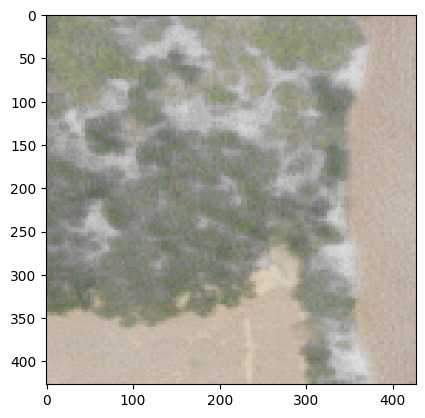

In [74]:
#plotting the sample naip image
image=naip_dataset[first_item]['image']
image=image.permute(1,2,0)
plt.imshow(image)
plt.show()